ver: 20201211.1100

In [36]:
# Initialization for this notebook.

import numpy as np
from scipy import signal
from scipy import fft
import matplotlib.pyplot as plt

# Common sequence generators.
seq_delta = lambda n_min, n_max: (np.array([ 1 if n==0 else 0 for n in range(n_min, n_max+1)]), 0 - n_min)
seq_u = lambda n_min, n_max: (np.array([ 0 if n<0 else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_R_N = lambda N, n_min, n_max: (np.array([ 0 if (n<0 or n>=N) else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_real_exp = lambda a, n_min, n_max: (np.array([ 0 if n<0 else a**n for n in range(n_min, n_max+1)]), 0-n_min)
seq_complex_exp = lambda sigma, omega_0, n_min, n_max: (np.array([ np.exp((sigma + 1j*omega_0)*n) for n in range(n_min, n_max+1)]), 0-n_min)
seq_sin = lambda A, omega_0, phi, n_min, n_max: (np.array([ A*np.sin(omega_0*n + phi) for n in range(n_min, n_max+1)]), 0-n_min)

# Un-comment the following line to use interactive matplotlib widget.
# %matplotlib widget

In [37]:
# A selection of tick format functions that can be used by `analyze_filter`.
def tick_format_rad_to_pi(value, tick_number):
    """Convert value (in rad) to multiple of pi."""
    return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'

def tick_format_append_pi(value, tick_number):
    """Append pi symbol to the value."""
    return ('%.2f' % (value)).rstrip('0').rstrip('.') + '$\pi$'

def tick_format_append_hz(value, tick_number):
    """Append Hz unit to the value."""
    return ('%.2f' % (value)).rstrip('0').rstrip('.') + 'Hz'

def analyze_filter(bands, b, a=1, show_plot=False, samples_per_band=129, fs=2, tick_format=tick_format_append_pi, amp_in_dB=True):
    """Find the R_p and A_s of the given filter and optionally show the frequency response plots.
    
    Parameters:
      bands : array_like
        A list of tuples, `(band_type, band_start, band_end)`, to describe each band.
        `band_type`: str, one of 'pass', 'tran', 'stop'
        `band_start`, `band_end`: float, the start and end frequencies, normalized to `fs`.
      b : array_like
        Numerator of the transfer function.
      a : array_like, optional
        Denominator of the transfer function. Default is 1 (FIR filter).
      show_plot : bool, optional
        Set to True to show the frequency response plots. Default is False.
      samples_per_band : int, optional
        Number of frequency samples per band (pass, transition and stop). Generally, more samples will give more accurate results. Default is 129.
      fs: float, optional
        Sampling frequency. Default is 2. (Tips: set to 2*numpy.pi for representing frequencies in rad/sample.)
      tick_format: function, optional
        Function to format tick values on x-axis. Default is `tick_format_append_pi`, which append a pi symbol to the values.
      amp_in_dB: bool, optional
        Whether the amplitude is represented in dB or not. Default is True.
    
    Returns:
      R_p: float
        Pass band ripple, in dB if amp_in_dB is True.
      A_s: float
        Stop band attenuation, in dB if amp_in_dB is True.
    """

    if amp_in_dB:
      dB = lambda x: 20 * np.log10(x)
      amp_unit = '(dB)'
    else:
      dB = lambda x: x
      amp_unit = ''

    NUM_BANDS = len(bands)
    [BAND_TYPE, BAND_START, BAND_END] = range(3)

    # Compute frequency respone samples for each band.
    w = []      # To store frequency samples for each band.
    H = []      # To store frequency respone samples for each band.
    for (band_type, w_start, w_end) in bands:
        w_tmp, H_tmp = signal.freqz(
          b=b, a=a, 
          worN=np.linspace(w_start, w_end, samples_per_band), 
          fs=fs)
        w.append(w_tmp)
        H.append(H_tmp)

    # Normalize |H| to 1.     
    H_abs = np.abs(H)
    H_norm_factor = np.max(H_abs)
    H = H / H_norm_factor
    H_abs = H_abs / H_norm_factor

    # Find the minimum pass band ripple and maximum stop band attenuation (across all respective bands).
    pass_min = 1
    stop_max = 0
    for band in range(NUM_BANDS):
      band_type = bands[band][BAND_TYPE]
      if band_type=='pass':
        pass_min = min(pass_min, np.min(H_abs[band]))
      elif band_type=='stop':
        stop_max = max(stop_max, np.max(H_abs[band]))
    pass_min, stop_max = dB(pass_min), dB(stop_max)
    
    if show_plot:
        NUM_PLOTS = 2
        [AMP_PLOT, PHASE_PLOT] = range(NUM_PLOTS)
        BAND_COLOR = {'pass':'green', 'tran':'blue', 'stop':'red'}

        fig, axs = plt.subplots(NUM_PLOTS, 1 ,sharex='col')

        # Plot the frequency response.
        for band in range(NUM_BANDS):
            band_type = bands[band][BAND_TYPE]
            axs[AMP_PLOT].plot(w[band], dB(H_abs[band]), color=BAND_COLOR[band_type])
            axs[PHASE_PLOT].plot(w[band], np.angle(H[band]), color=BAND_COLOR[band_type])
        axs[AMP_PLOT].legend([bands[band][0] for band in range(3)])
        axs[PHASE_PLOT].set_xlim(left=0, right=fs/2)
        axs[AMP_PLOT].set_ylabel('Amplitude' + amp_unit)
        axs[PHASE_PLOT].set_ylabel('Phase')
        axs[PHASE_PLOT].set_xlabel('Frequency')
        axs[AMP_PLOT].grid()
        axs[PHASE_PLOT].grid()

        # Set the tick format
        axs[PHASE_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format))
        axs[PHASE_PLOT].xaxis.set_major_locator(plt.MultipleLocator(fs/8))
        axs[PHASE_PLOT].yaxis.set_major_formatter(plt.FuncFormatter(tick_format_rad_to_pi))
        axs[PHASE_PLOT].yaxis.set_major_locator(plt.MultipleLocator(np.pi/2))

        # Add horizontal lines to indicate R_p and A_s.
        axs[AMP_PLOT].axhline(y=pass_min, linestyle='--', color=BAND_COLOR['pass'])
        axs[AMP_PLOT].axhline(y=stop_max, linestyle='--', color=BAND_COLOR['stop'])
        axs[AMP_PLOT].secondary_yaxis('right').set_yticks([pass_min, stop_max])

        # Add vertical lines to indicate band egdes.
        band_edges = []
        for band in range(NUM_BANDS):
          band_type, band_start, band_end = bands[band]
          if band_type=='tran':
            for plot in range(NUM_PLOTS):
              axs[plot].axvline(band_start, linestyle='--')
              axs[plot].axvline(band_end, linestyle='--')
              band_edges.append(band_start)
              band_edges.append(band_end)
        ax_phase_top = axs[PHASE_PLOT].secondary_xaxis('top')
        ax_phase_top.xaxis.set_major_formatter(plt.FuncFormatter(tick_format))
        ax_phase_top.set_xticks(band_edges)

    if amp_in_dB:
      R_p, A_s = -pass_min, -stop_max
    else:
      R_p, A_s = pass_min, stop_max
    return R_p, A_s

In [38]:
def test_filter(b, a, x):
    """Test a filter by comparing the input and output.

    Parameters:
      b : array_like
        Numerator of the transfer function.
      a : array_like
        Denominator of the transfer function.
      x : array_like
        Input sequence.
    
    Returns:
      y : array_like
        Output sequence.
    """
    y = signal.lfilter(b=b, a=a, x=x)

    X = fft.fft(x)
    Y = fft.fft(y)

    def tick_format_pi(value, tick_number):
        return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'

    NUM_PLOTS = 2
    [TIME_PLOT, FREQ_PLOT] = range(NUM_PLOTS)
    fig, axs = plt.subplots(NUM_PLOTS,1)

    N = len(x)
    n = np.arange(N)
    axs[TIME_PLOT].plot(n, x, linewidth=3, color='red', alpha=0.5)
    axs[TIME_PLOT].plot(n, y, linewidth=2, color='green');
    axs[TIME_PLOT].legend(['x', 'y'])
    axs[TIME_PLOT].set_xlabel('n')

    w = n*2*np.pi/N
    axs[FREQ_PLOT].plot(w, abs(X), color='red', alpha=0.5)
    axs[FREQ_PLOT].plot(w, abs(Y), color='green')
    axs[FREQ_PLOT].legend(['|X|', '|Y|'])
    axs[FREQ_PLOT].set_xlabel('$\omega$')
    axs[FREQ_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format_pi))
    axs[FREQ_PLOT].xaxis.set_major_locator(plt.MultipleLocator(np.pi/4))

    return y

【参考课本例6.10】设计Butterworth(/Chebyshev I/Chebyshev II/elliptic)型数字低通滤波器。给定性能指标为：在$f$<1kHz的通带内，幅度特性下降小于1dB，在频率大于$f_{st}$=1.5kHz的阻带内，衰减大于15dB，抽样频率为$f_s$=10kHz。

解：

IIR低通滤波器，可以直接使用 `scipy.signal.iirdesign()`函数设计。

type = ellip, order = 3, R_p = 1.000000, A_s = 15.000345
b = [ 0.12143986 -0.05114093 -0.05114093  0.12143986]
a = [ 1.         -2.11117646  1.78430357 -0.53252925]


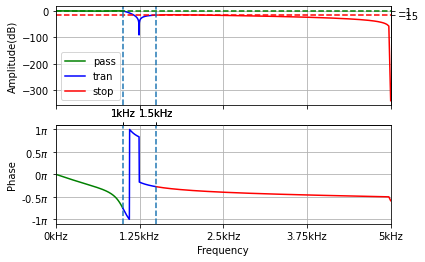

In [39]:
# All frequencies are in Hz.
fs = 10e3
f_p, f_st = 1e3, 1.5e3
R_p_target = 1      # in dB
A_s_traget = 15     # in dB

## Uncomment only one of the following:
# ftype='butter'
# ftype='cheby1'
# ftype='cheby2'
ftype='ellip'

b, a = signal.iirdesign(
    f_p, f_st, 
    R_p_target, A_s_traget,
    ftype=ftype,
    fs=fs)
forder = max(len(b), len(a)) - 1

# Analyze the filter.
bands= [
    ('pass', 0, f_p), 
    ('tran', f_p, f_st), 
    ('stop', f_st, fs/2)
    ]
def tick_format_to_khz(value, tick_number):
    """Show the value in kHz"""
    return ('%.2f' % (value/1000)).rstrip('0').rstrip('.') + 'kHz'
R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True, fs=fs, tick_format=tick_format_to_khz, amp_in_dB=True)
print('type = %s, order = %d, R_p = %f, A_s = %f' % (ftype, forder, R_p, A_s))
print('b =', b)
print('a =', a)

C:\Users\14491\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


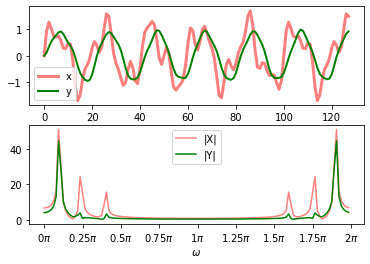

In [40]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 2*np.pi/fs * 0.5e3, 0))    # in the pass band
    x_comp.append((0.5, 2*np.pi/fs * 1.2e3, 0))    # in the tran band
    x_comp.append((0.3, 2*np.pi/fs * 2.0e3, 0))    # in the stop band
    
    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max) for A, w, phi in x_comp], axis=0)[0]

    return x

x = gen_signal()
test_filter(b, a, x);

【参考课本例6.12】设计一个Butterworth(/Chebyshev I/Chebyshev II/elliptic)型数字带通滤波器。技术指标为$f_{st1}$=0.6kHz，$f_{p1}$=1.2kHz，$f_{p2}$=3kHz，$f_{st2}$=4kHz，抽样频率$f_s$=10kHz，$R_p$=2dB，$A_s$=15dB。

解：

各种分段型IIR滤波器，可以使用 `scipy.signal.iirfilter()` 函数设计，但需要计算出所需要的阶数$N$和截止频率$f_c$。

f_c = [1117.80686713 3116.00560988]


C:\Users\14491\AppData\Local\Temp/ipykernel_12624/3649400875.py:45: RuntimeWarning: divide by zero encountered in log10
  dB = lambda x: 20 * np.log10(x)
C:\Users\14491\AppData\Local\Temp/ipykernel_12624/3649400875.py:45: RuntimeWarning: divide by zero encountered in log10
  dB = lambda x: 20 * np.log10(x)


type = butter, order = 2, R_p = 2.000000, A_s = 15.181562
b = [ 0.20628091  0.         -0.41256182  0.          0.20628091]
a = [ 1.         -0.69832014  0.50680216 -0.22469269  0.19599286]


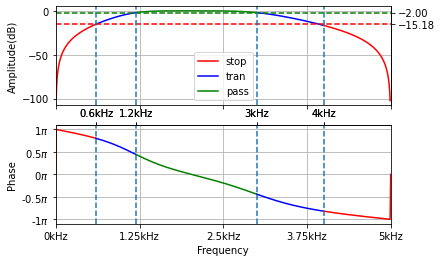

In [41]:
# All frequencies are in Hz.
fs = 10e3
f_st_1, f_p_1  = 0.6e3, 1.2e3
f_p_2 , f_st_2 = 3.0e3, 4.0e3
R_p_target = 2      # in dB
A_s_traget = 15     # in dB

## Uncomment only one of the following:
ftype, forder_function = 'butter', signal.buttord
# ftype, forder_function = 'cheby1', signal.cheb1ord
# ftype, forder_function = 'cheby2', signal.cheb2ord
# ftype, forder_function = 'ellip' , signal.ellipord

# Compute the order and cutoff frequencies.
forder, f_c = forder_function([f_p_1, f_p_2], [f_st_1, f_st_2], R_p_target, A_s_traget, fs=fs)
print('f_c =', f_c)

b, a = signal.iirfilter(
    forder,
    f_c,
    btype='bandpass',
    ftype=ftype,
    rp=R_p_target,
    rs=A_s_traget,
    fs=fs)

# Analyze the filter.
bands= [
    ('stop', 0,      f_st_1), 
    ('tran', f_st_1, f_p_1 ), 
    ('pass', f_p_1,  f_p_2 ), 
    ('tran', f_p_2,  f_st_2), 
    ('stop', f_st_2, fs/2)
    ]
def tick_format_to_khz(value, tick_number):
    """Show the value in kHz"""
    return ('%.2f' % (value/1000)).rstrip('0').rstrip('.') + 'kHz'
R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True, fs=fs, tick_format=tick_format_to_khz, amp_in_dB=True)
print('type = %s, order = %d, R_p = %f, A_s = %f' % (ftype, forder, R_p, A_s))
print('b =', b)
print('a =', a)

【思考】这里计算出来的$N=2$，但系统却是4阶的（$z^{-4}$的系数$a_4$、$b_4$都不为零），为什么？

答：带通滤波器，可以理解为是由一个高通串联上一个低通组成。从系统函数上看，即由一个2阶的高通系统函数乘上一个2阶的低通系统函数。因此总的系统是 $2 \times 2 = 4$ 阶。

C:\Users\14491\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


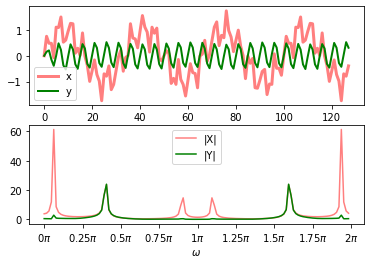

In [42]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 2*np.pi/fs * 0.3e3, 0))    # in the stop band
    x_comp.append((0.5, 2*np.pi/fs * 2.0e3, 0))    # in the pass band
    x_comp.append((0.3, 2*np.pi/fs * 4.5e3, 0))    # in the stop band
    
    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max) for A, w, phi in x_comp], axis=0)[0]

    return x

x = gen_signal()
test_filter(b, a, x);

# 【作业】

设计并分析数字低通滤波器。技术指标要求是：通带截止频率 $\omega_p=0.3\pi$，阻带截止频率为 $\omega_{st}=0.5\pi$，通带纹波 $R_p \leqslant 1 \text{dB}$、阻带衰减为 $A_s \geqslant 40\text{dB}$）。

- 分别设计阶数最少的FIR和IIR低通滤波器，并使用`analyze_filter()`和`test_filter()`函数对它们进行分析和测试。
- 输入以下序列，将输入、FIR滤波器的输出、IIR滤波器的输出画在同一个坐标系中，分析对比三个序列的异同并说明原因。
    - 输入一个频率在通带范围内的正弦序列
    - 输入序列 $x(n)=\sin(0.1\pi n) + 0.3 \sin(0.2\pi n)$

In [43]:
def output_arr(name, arr):
    result = 'float ' + name + f'[{len(arr)}] = {{'
    for ele in arr:
        result += f'{np.round(ele, 4)},'
    result += '};'
    print(result)

In [44]:
# All frequencies are in Hz.
# 采样频率 50Hz
fs = 50e3
w_p, w_st = 10e3, 22e3
R_p_target = 1      # in dB
A_s_traget = 75     # in dB

题目要求选用阶数最小的滤波器，这里我们选择ellip，因为其阶次最低

float fAn[6] = {1.0,-0.5745,0.749,-0.205,0.0737,-0.0056,};
float fBn[6] = {0.0324,0.1621,0.3242,0.3242,0.1621,0.0324,};
type = butter, order = 5, R_p = 1.000000, A_s = 79.956865
b = [0.03242287 0.16211433 0.32422865 0.32422865 0.16211433 0.03242287]
a = [ 1.         -0.57454968  0.74897788 -0.2050219   0.07371567 -0.00559027]


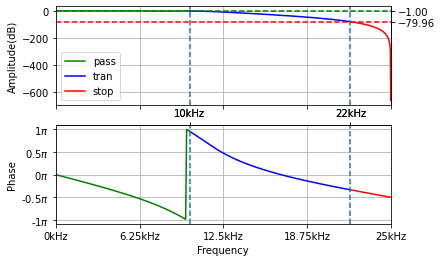

In [45]:
# Uncomment only one of the following:
ftype='butter'
# ftype='cheby1'
# ftype = 'cheby2'
#ftype = 'ellip'

b, a = signal.iirdesign(
    w_p, w_st,
    R_p_target, A_s_traget,
    ftype=ftype,
    fs=fs)
forder = max(len(b), len(a)) - 1

# Analyze the filter.
bands = [
    ('pass', 0, w_p),
    ('tran', w_p, w_st),
    ('stop', w_st, fs/2)
]

output_arr("fAn", a)
output_arr("fBn", b)


R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True,
                          fs=fs, tick_format=tick_format_to_khz, amp_in_dB=True)
print('type = %s, order = %d, R_p = %f, A_s = %f' % (ftype, forder, R_p, A_s))
print('b =', b)
print('a =', a)


float fAn[6] = {1.0,-0.5745,0.749,-0.205,0.0737,-0.0056,};
float fBn[6] = {0.0324,0.1621,0.3242,0.3242,0.1621,0.0324,};
type = butter, order = 5, R_p = 1.000000, A_s = 79.956865
b = [0.03242287 0.16211433 0.32422865 0.32422865 0.16211433 0.03242287]
a = [ 1.         -0.57454968  0.74897788 -0.2050219   0.07371567 -0.00559027]


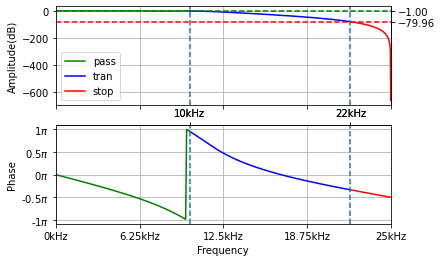

In [ ]:
# Uncomment only one of the following:
ftype='butter'
# ftype='cheby1'
# ftype = 'cheby2'
#ftype = 'ellip'

b, a = signal.iirdesign(
    w_p, w_st,
    R_p_target, A_s_traget,
    ftype=ftype,
    fs=fs)
forder = max(len(b), len(a)) - 1

# Analyze the filter.
bands = [
    ('pass', 0, w_p),
    ('tran', w_p, w_st),
    ('stop', w_st, fs/2)
]

output_arr("fAn", a)
output_arr("fBn", b)


R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True,
                          fs=fs, tick_format=tick_format_to_khz, amp_in_dB=True)
print('type = %s, order = %d, R_p = %f, A_s = %f' % (ftype, forder, R_p, A_s))
print('b =', b)
print('a =', a)


观察到，A_s=39.999808, 与要求中的40dB不相符
我们选择阶数次低的滤波器cheby1

type = cheby1, order = 4, R_p = 0.999933, A_s = 80.685515
b = [0.02426115 0.09704461 0.14556692 0.09704461 0.02426115]
a = [ 1.         -1.59771599  1.74592824 -1.0200446   0.30737576]


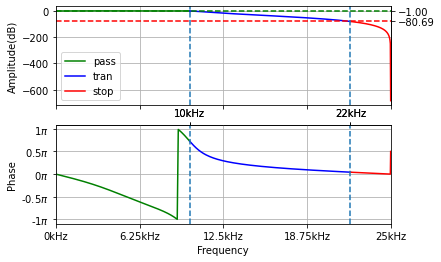

In [46]:
# Uncomment only one of the following:
# ftype='butter'
ftype='cheby1'
# ftype = 'cheby2'
# ftype = 'ellip'

b, a = signal.iirdesign(
    w_p, w_st,
    R_p_target, A_s_traget,
    ftype=ftype,
    fs=fs)
forder = max(len(b), len(a)) - 1

# Analyze the filter.
bands = [
    ('pass', 0, w_p),
    ('tran', w_p, w_st),
    ('stop', w_st, fs/2)
]


R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True,
                          fs=fs, tick_format=tick_format_to_khz, amp_in_dB=True)
print('type = %s, order = %d, R_p = %f, A_s = %f' % (ftype, forder, R_p, A_s))
print('b =', b)
print('a =', a)


观察到，此时通带最大衰减与阻带最小衰减均符合要求

## 测试IIR滤波器

C:\Users\14491\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([ 0.        ,  0.02499905,  0.15662201,  0.43563162,  0.73531204,
        0.86357823,  0.69770429,  0.21184839, -0.42071314, -0.87868727,
       -0.97682293, -0.72064135, -0.19463667,  0.40515753,  0.83814721,
        0.97295936,  0.75335459,  0.21707741, -0.40716254, -0.85511596,
       -0.98668667, -0.74294671, -0.20015049,  0.40153456,  0.84324677,
        0.98725068,  0.74550156,  0.20415826, -0.39685833, -0.85035563,
       -0.99345461, -0.73797396, -0.20127616,  0.39230259,  0.85199586,
        0.99281533,  0.7342702 ,  0.2065244 , -0.3902641 , -0.85853151,
       -0.99118269, -0.73052078, -0.21067759,  0.39149253,  0.8619262 ,
        0.98612078,  0.730693  ,  0.2158994 , -0.39537137, -0.86366882,
       -0.98122482, -0.73351511, -0.21825385,  0.40057648,  0.86169667,
        0.9774675 ,  0.73847845,  0.21784448, -0.40499728, -0.85746187,
       -0.97676624, -0.74342098, -0.21431084,  0.40702904,  0.85223338,
        0.9791309 ,  0.74657792,  0.2092684 , -0.40584204, -0.84

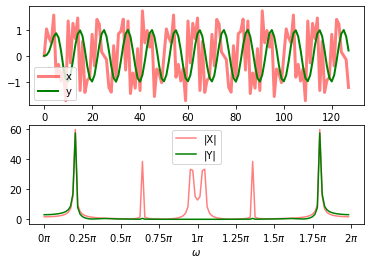

In [47]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 5e3 * 2 * np.pi / fs, 0))    # in the pass band
    x_comp.append((0.6, 16e3 * 2 * np.pi / fs, 0))    # in the tran band
    x_comp.append((0.8, 26e3 * 2 * np.pi / fs, 0))    # in the stop band

    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max)
               for A, w, phi in x_comp], axis=0)[0]

    return x


x = gen_signal()
test_filter(b, a, x)


观察到，通带信号得到保留，阻带、过渡带信号被滤除

## FIR滤波器

根据上一次作业，选择凯泽窗

type = cheby1, N = 21, R_p = 0.002582, A_s = 74.174503
b = [ 3.10805267e-19 -2.29175572e-05  8.16965943e-04 -1.60868819e-03
 -1.90408517e-03  1.00433903e-02 -8.68942267e-03 -1.79656723e-02
  4.92444494e-02 -2.04110518e-02 -1.09508030e-01  2.80013836e-01
  6.39982453e-01  2.80013836e-01 -1.09508030e-01 -2.04110518e-02
  4.92444494e-02 -1.79656723e-02 -8.68942267e-03  1.00433903e-02
 -1.90408517e-03 -1.60868819e-03  8.16965943e-04 -2.29175572e-05
  3.10805267e-19]
a = 1
float fHn[25] = {0.0,-0.0,0.001,-0.002,-0.002,0.01,-0.009,-0.018,0.049,-0.02,-0.11,0.28,0.64,0.28,-0.11,-0.02,0.049,-0.018,-0.009,0.01,-0.002,-0.002,0.001,-0.0,0.0,};


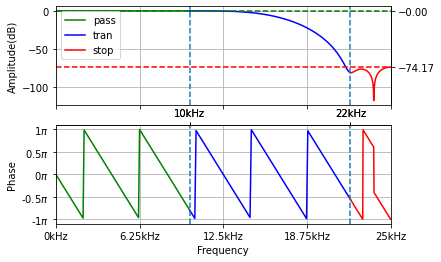

In [48]:
# 过渡带宽度
f_tran = abs(w_p - w_st)

# Compute window property.
# 过渡带宽度，表示为 过渡带带宽 / 奈奎斯特频率
width = f_tran / (fs / 2)
# 使用kaiserord计算凯泽窗参数，第一个参数为阻带最小衰减(单位dB), 第二个参数为过渡带宽度
N, beta = signal.kaiserord(A_s_traget, width)
window = ('kaiser', beta)

# Compute the FIR coefficients.
w_c = (w_p + w_st) / 2
FIR_b = signal.firwin(25, w_c, window="blackman", fs=fs)
FIR_a = 1

R_p, A_s = analyze_filter(bands, b=FIR_b, a=FIR_a, show_plot=True,
                          fs=fs, tick_format=tick_format_to_khz, amp_in_dB=True)
print('type = %s, N = %d, R_p = %f, A_s = %f' % (ftype, N, R_p, A_s))
print('b =', FIR_b)
print('a =', FIR_a)

output_arr("fHn", np.round(FIR_b, 3))


观察到，FIR滤波器通带最大衰减和阻带最小衰减均符合要求

## 测试FIR滤波器

In [49]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 5e3 * 2 * np.pi / fs, 0))    # in the pass band
    x_comp.append((0.6, 16e3 * 2 * np.pi / fs, 0))    # in the tran band
    x_comp.append((0.8, 26e3 * 2 * np.pi / fs, 0))    # in the stop band

    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max)
               for A, w, phi in x_comp], axis=0)[0]

    return x


x = gen_signal()

with open("fIn.dat", "w") as fIn:
    fIn.write(f"1651 4 0 1 {len(x):x} 0\n")
    for val in x:
        fIn.write(f"{val}\n")
    fIn.flush()
    fIn.close()

C:\Users\14491\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [50]:
# 计算多项式
poly_a = np.poly1d(a)
poly_b = np.poly1d(b)
print(f'多项式A = \n {poly_a}\n 极点 = \n{poly_a.r}')
print(f'多项式B = \n {poly_b}\n 零点 = \n{poly_b.r}')

多项式A = 
    4         3         2
1 x - 1.598 x + 1.746 x - 1.02 x + 0.3074
 极点 = 
[0.27807373+0.82908913j 0.27807373-0.82908913j 0.52078427+0.36156949j
 0.52078427-0.36156949j]
多项式B = 
          4           3          2
0.02426 x + 0.09704 x + 0.1456 x + 0.09704 x + 0.02426
 零点 = 
[-1.00021915+0.j         -0.99999998+0.00021913j -0.99999998-0.00021913j
 -0.99978088+0.j        ]


In [54]:
import sympy
x, y, z, t = sympy.symbols('x y z t')
sympy.simplify(((z**4+poly_b.r[0])*(z**3+poly_b.r[1])*(z**2+poly_b.r[2])*(z**1+poly_b.r[3])*(z**0+poly_b[4]))
 / ((z**4+poly_a.r[0])*(z**3+poly_a.r[1])*(z**2+poly_a.r[2])*(z**1+poly_a.r[3])), )

-1.02426115367733*(z - 0.999780881875745)*(z**4 - 1.00021915166593)*(-z**2 + 0.999999983229167 + 0.000219134890909673*I)*(z**3 - 0.999999983229167 + 0.000219134890909673*I)/((z + 0.520784270317027 - 0.361569492164242*I)*(z**2 + 0.520784270317027 + 0.361569492164242*I)*(z**3 + 0.278073726532772 - 0.829089134565532*I)*(z**4 + 0.278073726532772 + 0.829089134565532*I))

In [52]:
def test_filter_with_ccs_data(b, a, x, ccs_y):
    """Test a filter by comparing the input and output.

    Parameters:
      b : array_like
        Numerator of the transfer function.
      a : array_like
        Denominator of the transfer function.
      x : array_like
        Input sequence.
      ccs_y: array_like
        CCS output sequence
    
    Returns:
      y : array_like
        Output sequence.
      ccs_y : array_like
        CCS Output sequence
    """
    y = signal.lfilter(b=b, a=a, x=x)

    X = fft.fft(x)
    Y = fft.fft(y)
    # CCS 序列傅里叶变换
    CCS_Y = fft.fft(ccs_y)

    # 检查Python计算结果是否与CCS相同
    assert (np.abs(y - ccs_y) < 0.5).all(), f"{np.abs(y - ccs_y)}"
    print("Asserted Python equals CCS values")

    def tick_format_pi(value, tick_number):
        return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'

    NUM_PLOTS = 2
    [TIME_PLOT, FREQ_PLOT] = range(NUM_PLOTS)
    fig, axs = plt.subplots(NUM_PLOTS,1)

    N = len(x)
    n = np.arange(N)
    axs[TIME_PLOT].plot(n, x, linewidth=3, color='red', alpha=0.5)
    axs[TIME_PLOT].plot(n, y, linewidth=3, color='green', alpha=0.5);
    axs[TIME_PLOT].plot(n, ccs_y, linewidth=1, color='blue');
    axs[TIME_PLOT].legend(['x', 'y', 'ccs_y'])
    axs[TIME_PLOT].set_xlabel('n')

    w = n*2*np.pi/N
    axs[FREQ_PLOT].plot(w, abs(X), color='red', alpha=0.5)
    axs[FREQ_PLOT].plot(w, abs(Y), color='green', alpha=0.5)
    axs[FREQ_PLOT].plot(w, abs(CCS_Y), color='blue')
    axs[FREQ_PLOT].legend(['|X|', '|Y|', '|CCS Y|'])
    axs[FREQ_PLOT].set_xlabel('$\omega$')
    axs[FREQ_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format_pi))
    axs[FREQ_PLOT].xaxis.set_major_locator(plt.MultipleLocator(np.pi/4))

    return y, ccs_y

ccs_y = np.array([])
with open("C:/Users/14491/Desktop/fOut.dat", "r") as fOut:
    # Skip file header
    fOut.readline()
    ccs_y = np.array([float(val) for val in fOut.readlines()])

_, _ = test_filter_with_ccs_data(b, a, x, ccs_y)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/14491/Desktop/fOut.dat'

In [ ]:
def test_filter_IIR_FIR(IIR_b, IIR_a, FIR_b, FIR_a, x):
    """Test a filter by comparing the input and output.

    Parameters:
      IIR_b : array_like
        Numerator of the IIR transfer function.
      IIR_a : array_like
        Denominator of the IIR transfer function.
      FIR_b : array_like
        Numerator of the FIR transfer function.
      FIR_a : array_like
        Denominator of the FIR transfer function.
      x : array_like
        Input sequence.
    
    Returns:
      IIR_y : array_like
        Output sequence of IIR.
      FIR_y : array_like
        Output sequence of IIR.
    """
    IIR_y = signal.lfilter(b=IIR_b, a=IIR_a, x=x)  # IIR滤波器输出
    FIR_y = signal.lfilter(b=FIR_b, a=FIR_a, x=x)  # FIR滤波器输出

    X = fft.fft(x)
    IIR_Y = fft.fft(IIR_y)
    FIR_Y = fft.fft(FIR_y)

    def tick_format_pi(value, tick_number):
        return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'

    NUM_PLOTS = 2
    [TIME_PLOT, FREQ_PLOT] = range(NUM_PLOTS)
    fig, axs = plt.subplots(NUM_PLOTS, 1)

    N = len(x)
    n = np.arange(N)
    axs[TIME_PLOT].plot(n, x, linewidth=3, color='red', alpha=0.5)
    axs[TIME_PLOT].plot(n, IIR_y, linewidth=2, color='green')
    axs[TIME_PLOT].plot(n, FIR_y, linewidth=1, color='blue')
    axs[TIME_PLOT].legend(['x', 'IIR_y', 'FIR_y'])
    axs[TIME_PLOT].set_xlabel('n')

    w = n*2*np.pi/N
    axs[FREQ_PLOT].plot(w, abs(X), color='red', alpha=0.5)
    axs[FREQ_PLOT].plot(w, abs(IIR_Y), color='green')
    axs[FREQ_PLOT].plot(w, abs(FIR_Y), color='blue')
    axs[FREQ_PLOT].legend(['|X|', '|IIR_Y|', '|FIR_Y|'])
    axs[FREQ_PLOT].set_xlabel('$\omega$')
    axs[FREQ_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format_pi))
    axs[FREQ_PLOT].xaxis.set_major_locator(plt.MultipleLocator(np.pi/4))

    return IIR_y, FIR_y

输入一个频率在通带范围内的正弦序列

C:\Users\14491\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([ 0.00000000e+00,  7.49710879e-03,  5.62270341e-02,  1.98397149e-01,
         4.43596314e-01,  7.16264076e-01,  9.06322159e-01,  9.58417406e-01,
         8.94507727e-01,  7.59028789e-01,  5.67148179e-01,  3.12930049e-01,
         9.06655697e-03, -3.00812857e-01, -5.68703059e-01, -7.69227812e-01,
        -8.97054025e-01, -9.47273033e-01, -9.08454273e-01, -7.75035006e-01,
        -5.59852942e-01, -2.90980235e-01,  1.22582699e-03,  2.91295753e-01,
         5.55675076e-01,  7.68780827e-01,  9.06214292e-01,  9.52325146e-01,
         9.04081487e-01,  7.68709183e-01,  5.59718379e-01,  2.95796342e-01,
         1.59534778e-03, -2.93389750e-01, -5.58992252e-01, -7.69027394e-01,
        -9.03819816e-01, -9.50808989e-01, -9.05071571e-01, -7.70419897e-01,
        -5.59912455e-01, -2.94595595e-01, -7.78730470e-04,  2.92925921e-01,
         5.58109899e-01,  7.68891362e-01,  9.04418867e-01,  9.51246133e-01,
         9.04856560e-01,  7.69966019e-01,  5.59824453e-01,  2.94893744e-01,
         1.0

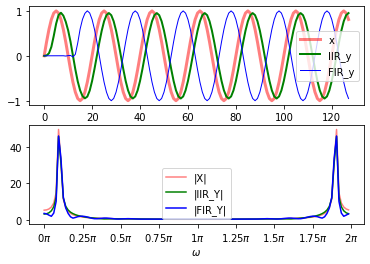

In [ ]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 0.1*np.pi, 0))    # in the pass band

    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max)
               for A, w, phi in x_comp], axis=0)[0]

    return x


x = gen_signal()
test_filter_IIR_FIR(b, a, FIR_b, FIR_a, x)


观察到，两个滤波器输出信号与输入信号相比均有一个延迟，IIR滤波器相位延迟比FIR相位延时更小，IIR输出的信号相比FIR有一定的衰减

原因：FIR滤波器阶数比IIR更高

输入序列 $x(n)=\sin(0.1\pi n) + 0.3 \sin(0.2\pi n)$

C:\Users\14491\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([ 0.        ,  0.01177521,  0.08709677,  0.30052817,  0.64785191,
         0.9850783 ,  1.12988603,  1.02323586,  0.76316089,  0.49081192,
         0.27472384,  0.10410204, -0.04724971, -0.18603294, -0.31951121,
        -0.47413223, -0.67025419, -0.88122076, -1.03048375, -1.03529695,
        -0.85557113, -0.50983472, -0.06010864,  0.4097585 ,  0.81029746,
         1.064086  ,  1.12916681,  1.01627192,  0.78394976,  0.51116648,
         0.26406631,  0.07488286, -0.06095382, -0.17404128, -0.30295454,
        -0.47361351, -0.68188781, -0.88751107, -1.02478238, -1.02723163,
        -0.85547971, -0.516021  , -0.06367764,  0.41247122,  0.81452445,
         1.06436429,  1.12609554,  1.01435692,  0.78523695,  0.51334812,
         0.26429526,  0.07334129, -0.06198683, -0.1734373 , -0.30182884,
        -0.47344934, -0.6826573 , -0.8880645 , -1.02450169, -1.02665229,
        -0.85537215, -0.51640421, -0.06397302,  0.41259999,  0.81482194,
         1.06443126,  1.12590529,  1.0141999 ,  0.7

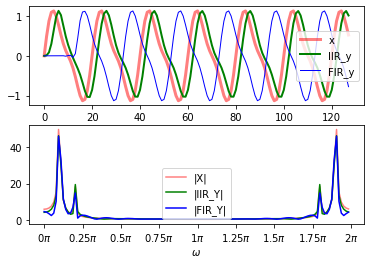

In [ ]:
def gen_signal():
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((1.0, 0.1*np.pi, 0))    # in the pass band  sin(0.1πn)
    x_comp.append((0.3, 0.2*np.pi, 0))    # in the pass band  0.3sin(0.2πn)

    # Generate the sequence by combining all sin components.
    n_min, n_max = 0, 127
    x = np.sum([seq_sin(A, w, phi, n_min, n_max)
               for A, w, phi in x_comp], axis=0)[0]

    return x


x = gen_signal()
test_filter_IIR_FIR(b, a, FIR_b, FIR_a, x)


观察到，两个滤波器输出信号与输入信号相比均有一个延迟，IIR滤波器相位延迟比FIR相位延时更小，IIR输出的信号相比FIR有一定的衰减

原因：FIR滤波器阶数比IIR更高